# Installs and imports

In [1]:
# Install all dependencies for segmentation-models-3D library.
# We will use this library to call 3D unet.
# Alternative, you can define your own Unet, if you have skills!
!pip install classification-models-3D --quiet
!pip install efficientnet-3D --quiet
!pip install segmentation-models-3D --quiet

# Use patchify to break large volumes into smaller for training 
# and also to put patches back together after prediction.
!pip install patchify --quiet

# volumentations-3D is a data augmentation library. 
# It provides usful tools to augment 3D volumes, while classic librairies
# only provide augmentation for 2D images.
!pip install volumentations-3D --quiet

In [2]:
# import data
PATH_COLAB = '/content/drive/MyDrive/6_aneurysm_segmentation/challenge_dataset.zip'
PATH_DEVICE = './challenge_dataset/'

try:
    from google.colab import drive
    # connect your drive to the session
    drive.mount('/content/drive')

    %cd /content/drive/MyDrive/6_aneurysm_segmentation/

    # unzip data into the colab session
    ! unzip -q $PATH_COLAB -d /content

except:
    data_exists = os.path.exists(PATH_DEVICE)
    
    if data_exists:
        print(f"Dataset found on device at : '{PATH_DEVICE}.'") 
    else:
        raise FileNotFoundError(f"Data folder not found at '{PATH_DEVICE}'")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1n-EXfZBcfpt6CpyrB9pO2K3R2f3PZ28s/6_aneurysm_segmentation
replace /content/challenge_dataset/scan_1.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [14]:
import os
import random
import h5py
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# funky librairies for segmentation
import segmentation_models_3D as sm # pretrained models
from patchify import patchify, unpatchify # helps cropping images to create more training subimages

from sequence import DataGenerator # for custom generators
from custom3dUnet import build_unet, unet3d_BN
from utils import load_data_from, analytics
from volumentations import * # 3d augmentation tools

print('All librairies sucessfully imported.')

All librairies sucessfully imported.


# Get data

In [118]:
PATH_DATASET = './challenge_dataset/'
TEST_SPLIT = 0.2 # % of test samples from the full dataset
VAL_SPLIT = 0.2 # % of training samples kept for the validation metrics
BATCH_SIZE = 2
SEED = 1234 # random seed for replicable random steps

# The whole volume (64,192,192) can be split in 9 cubes (64,64,64).
# Most aneurysms are inside the center one. You can :
#  - train on the full volumes    ---> CROP = None
#  - split volumes in cubes :     ---> CROP = 64
#       - train on the center one only ---> CENTER_CUBE_ONLY = True
#       - train on the 9 cubes         ---> CENTER_CUBE_ONLY = False

# -------------------- CHOOSE WHICH DATA YOU WANT TO USE --------------------

# 1. CUBES ? or entire volume ?
CROP = None # None or 64, None keeps the samples unchanged, 64 crops them to (64,64,64)
CENTER_CUBE_ONLY = False # False train on all data (split volume in 9 cubes), True train only on the middle (64,64,64) cube around the aneurysm = less data

# 2. Data augmentation ?
# if True, augmentation is applied, to define later
# if False, input will be the raw np arrays
USE_GENERATORS = True 

## Convert .h5 to numpy arrays

**Note:** This approach is not scalable. If the files were heavier and couldn't hold in memory, we should have opened the .h5 files only inside the generators. For sake of simplicity, here, he load data into numpy arrays, and will feed them to generators later (for augmentation).

In [119]:
raw_data, labels, names = load_data_from(PATH_DATASET, 
                                         crop=CROP, 
                                         center_cube_only=CENTER_CUBE_ONLY)
# check shapes
print(raw_data.shape)
print(labels.shape)

103 samples in dataset.
['scan_1.h5', 'scan_3.h5', 'scan_2.h5', 'scan_4.h5', 'scan_5.h5', 'scan_6.h5', 'scan_7.h5', 'scan_8.h5', 'scan_9.h5', 'scan_11.h5', 'scan_10.h5', 'scan_13.h5', 'scan_14.h5', 'scan_12.h5', 'scan_16.h5', 'scan_18.h5', 'scan_17.h5', 'scan_15.h5', 'scan_19.h5', 'scan_20.h5', 'scan_21.h5', 'scan_23.h5', 'scan_22.h5', 'scan_24.h5', 'scan_27.h5', 'scan_26.h5', 'scan_28.h5', 'scan_25.h5', 'scan_31.h5', 'scan_29.h5', 'scan_30.h5', 'scan_34.h5', 'scan_35.h5', 'scan_33.h5', 'scan_32.h5', 'scan_38.h5', 'scan_37.h5', 'scan_36.h5', 'scan_40.h5', 'scan_41.h5', 'scan_39.h5', 'scan_43.h5', 'scan_42.h5', 'scan_44.h5', 'scan_48.h5', 'scan_46.h5', 'scan_45.h5', 'scan_47.h5', 'scan_51.h5', 'scan_49.h5', 'scan_50.h5', 'scan_55.h5', 'scan_54.h5', 'scan_53.h5', 'scan_52.h5', 'scan_57.h5', 'scan_58.h5', 'scan_56.h5', 'scan_60.h5', 'scan_61.h5', 'scan_59.h5', 'scan_64.h5', 'scan_62.h5', 'scan_63.h5', 'scan_65.h5', 'scan_66.h5', 'scan_67.h5', 'scan_70.h5', 'scan_69.h5', 'scan_68.h5', 'sca

100%|██████████| 103/103 [00:03<00:00, 27.87it/s]


(103, 64, 192, 192)
(103, 64, 192, 192)


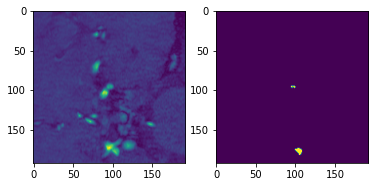

In [120]:
# if you train on all cubes, try 4, 13, 22, 31 and so on (center cubes)
SCAN_ID = 4 
DEPTH = 32

fig, ax = plt.subplots(1, 2)
ax[0].imshow(raw_data[SCAN_ID,DEPTH,:,:])
ax[1].imshow(labels[SCAN_ID,DEPTH,:,:]) 
plt.show()

##Train / val / test split

In [48]:
# split train and test data
X_train, X_test, y_train, y_test = train_test_split(raw_data, labels, test_size=TEST_SPLIT, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=VAL_SPLIT, random_state=SEED)

# train_test_split returns lists, we want arrays for easier calls
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

y_train = np.array(y_train, dtype='float32')
y_val = np.array(y_val, dtype='float32')
y_test = np.array(y_test, dtype='float32')

# check shapes
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(65, 64, 192, 192)
(17, 64, 192, 192)
(21, 64, 192, 192)


## Data augmentation

In [122]:
def get_augmentation(patch_size):
    """
    Create an augmentator, will be used by the generator.
    Check volumentations-3D for more info.
    """
    return Compose([
        # Rotate((-25, 25), (0, 0), (0, 0), p=0.5),
        # RandomCropFromBorders(crop_value=0.1, p=0.5),
        # ElasticTransform((0, 0.25), interpolation=2, p=0.1),
        # Resize(patch_size, interpolation=1, resize_type=0, always_apply=True, p=0.5),
        Flip(0, p=0.5),
        Flip(1, p=0.5),
        Flip(2, p=0.5),
        # RandomRotate90((1, 2), p=0.5),
        # GaussianNoise(var_limit=(0, 5), p=0.2),
        # RandomGamma(gamma_limit=(80, 120), p=0.2),
    ], p=1.0)

Then create generators to augment these sets during training.
Validation and test generators don't augment data.
We use them just to unify the way data is processed.

In [123]:
# Depending on if you train on the whole volume or on cubes you should consider 
# modifying it to match your case.

INPUT_GEN_SHAPE = X_train[0].shape # Shape of the images given as x and y to DataGenerators
print('input generator shape:', INPUT_GEN_SHAPE)

# define 3 generators
aug = get_augmentation(INPUT_GEN_SHAPE)

gen_train = DataGenerator(raw_data=X_train, 
                          labels=y_train, 
                          augmentator=aug,
                          batch_size=BATCH_SIZE,
                          input_shape=INPUT_GEN_SHAPE,
                          shuffle=True,
                          )

gen_val = DataGenerator(raw_data=X_val, 
                        labels=y_val, 
                        augmentator=None,
                        batch_size=BATCH_SIZE,
                        input_shape=INPUT_GEN_SHAPE,
                        shuffle=True,
                         )

gen_test = DataGenerator(raw_data=X_test, 
                         labels=y_test, 
                         augmentator=None,
                         batch_size=BATCH_SIZE,
                         input_shape=INPUT_GEN_SHAPE,
                         shuffle=True,
                         )

input generator shape: (64, 192, 192)


batch shape images : (2, 64, 192, 192, 1)
batch shape masks : (2, 64, 192, 192, 1)


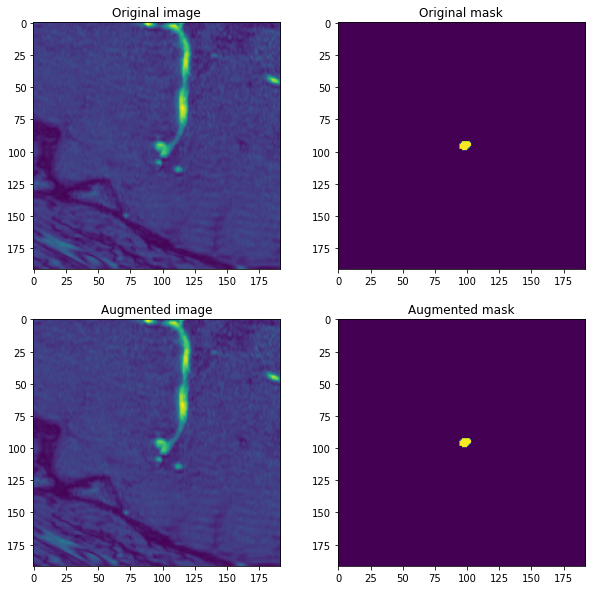

In [124]:
# Sanity check of the DataGenerator - here we try on the whole dataset.
# If you tried with X_train_prep, because of the shuffling, you couldn't 
# compare the original and augmented plots

ID = 0 # must be smaller than the batchsize. Same as previously (4, 13, 22 ...)
SLICE = 32 # [0, 64]

gen_example = DataGenerator(raw_data=raw_data, 
                            labels=labels, 
                            augmentator=aug,
                            batch_size=BATCH_SIZE,
                            input_shape=INPUT_GEN_SHAPE,
                            shuffle=True,
                            ) 

# gen is an iterator, get first element = a batch of images and their labels
batch_x, batch_y = gen_example[0]

# only keep one slice of the ID-th image of the batch
img = raw_data[ID, SLICE]
lbl = labels[ID, SLICE]

# one more dimension for augmented images, so keep first channel
aug_img = batch_x[ID, SLICE,:,:,0]
aug_lbl = batch_y[ID, SLICE,:,:,0]

print('batch shape images :', batch_x.shape)
print('batch shape masks :', batch_y.shape)

# visualize an original image and its mask, and their augmentations
plt.figure(figsize=(10, 10))
plt.subplot(221, title='Original image')
plt.imshow(img)
plt.subplot(222, title='Original mask')
plt.imshow(lbl)
plt.subplot(223, title='Augmented image')
plt.imshow(aug_img)
plt.subplot(224, title='Augmented mask')
plt.imshow(aug_lbl)
plt.show()

# Model parameters

We use pretrained models as backbones for the encoder part of our Unet 3D. There are multiple possible choices:

> Backbones: ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'seresnet18', 'seresnet34', 'seresnet50', 'seresnet101', 'seresnet152', 'seresnext50', 'seresnext101', 'senet154', 'resnext50', 'resnext101', 'vgg16', 'vgg19', 'densenet121', 'densenet169', 'densenet201', 'inceptionresnetv2', 'inceptionv3', 'mobilenet', 'mobilenetv2', 'efficientnetb0', 'efficientnetb1', 'efficientnetb2', 'efficientnetb3', 'efficientnetb4', 'efficientnetb5', 'efficientnetb6', 'efficientnetb7']

So far, what worked best for our dataset is:
```
OPTION = 'sm'
BACKBONE = 'resnet50'
LOSS_TYPE = 'jaccard'
BATCH_SIZE = 2 # 8 if (64,64,64) / 2 if (64,192,192)
LR = 1e-4
```

In [129]:
# Define the model. Here we use Unet but we can also use other model architectures from the library.

# OPTION 1 - 'sm'      - Architectures from segmntations-models-3d library
# OPTION 2 - 'custom1' - Simpler 3D unet 
# OPTION 3 - 'custom2' - Simpler 3D unet + Batch norm

# MODEL PARAMETERS
OPTION = 'sm'
encoder_weights = None # Try 'imagenet' or None (random initialization)
BACKBONE = 'resnet18'  # Try vgg16, efficientnetb7, inceptionv3, resnet50, resnet18
activation = 'sigmoid' # final layer activation function, sigmoid for binary
LOSS_TYPE = 'jaccard' # check dict 'losses' down below

n_channels_input = 1 # 1: grayscale, 3: RGB
n_classes = 1 # num channels output, here binary segmentation so 1
INPUT_MODEL_SHAPE = X_train.shape[1:] + (n_channels_input,)

# TRAINING PARAMETERS
MAX_EPOCHS = 100
LR = 1e-4 # starting learning rate
MIN_LR = 1e-3 * LR
PATIENCE_LR_PLATEAU = 5
PATIENCE_EARLY_STOPPING = 20

## Choose loss, metrics, callbacks

In [126]:
if OPTION == 'sm':
    model = sm.Unet(BACKBONE, classes=n_classes, 
                    input_shape=INPUT_MODEL_SHAPE, 
                    encoder_weights=encoder_weights,
                    activation=activation)
    MODEL_NAME = f'./3D_model_{BACKBONE}_{encoder_weights}weights_{MAX_EPOCHS}epochs_{LOSS_TYPE}'
    
elif OPTION == 'custom1':
    input_layer = Input((64, 64, 64, 1))
    model = build_unet(input_layer, 'he_normal')
    MODEL_NAME = f'./3D_model_{OPTION}_{MAX_EPOCHS}epochs_{LOSS_TYPE}'

elif OPTION == 'custom2':
    model = unet3d_BN((64, 64, 64, 1))
    MODEL_NAME = f'./3D_model_{OPTION}_{MAX_EPOCHS}epochs_{LOSS_TYPE}'
    
else:
    raise Exception('Not a valid option.')

print(MODEL_NAME)

./3D_model_resnet18_Noneweights_100epochs_jaccard


In [138]:
# ========= Define the optimizer and the loss =========
optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss() 
jaccard_loss = sm.losses.JaccardLoss()
focal_loss = sm.losses.BinaryFocalLoss()

# The keys (ex. 'dice') are the names expected as BACKBONE values defined above.
# It seems like the focal loss doesn't work here.
losses = {'dice': dice_loss,
          'jaccard': jaccard_loss,
          'focal_loss': focal_loss,
          'dice_focal': dice_loss + (1 * focal_loss), 
          'jaccard_focal': jaccard_loss + (1 * focal_loss), 
          }

total_loss = losses.get(LOSS_TYPE)
assert total_loss is not None, ('Loss not defined. Check your spelling of LOSS_TYPE or the dict losses.')

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 
metrics = [sm.metrics.IOUScore(threshold=0.5), 
           sm.metrics.FScore(threshold=0.5),]

In [139]:
# ========= add callbacks to monitor training =========
weight_path = "{}.best.hdf5".format(MODEL_NAME)

checkpoint = ModelCheckpoint(weight_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             save_weights_only=False)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', 
                                   factor=0.1, 
                                   patience=PATIENCE_LR_PLATEAU, 
                                   verbose=1, 
                                   mode='auto', 
                                   min_delta=0.0001, 
                                   cooldown=3, 
                                   min_lr=MIN_LR)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=PATIENCE_EARLY_STOPPING) 

callbacks_list = [checkpoint, 
                  early, 
                  reduceLROnPlat]

# Compile and train your model

In [140]:
# compile model - specify training 
model.compile(optimizer=optim, loss=total_loss, metrics=metrics)

# print info about the model
print(MODEL_NAME)
print(f'Your model has {model.count_params():,} parameters.')
# print(model.summary())

./3D_model_resnet18_Noneweights_100epochs_jaccard_finetuned_augmentTrue
Your model has 42,623,476 parameters.


In [ ]:
# Fit the model
if USE_GENERATORS:
    history = model.fit(x=gen_train,
                        validation_data=gen_val,
                        batch_size=BATCH_SIZE, 
                        epochs=MAX_EPOCHS,
                        verbose=1,
                        callbacks=callbacks_list)
    
else: 
    history = model.fit(x=np.expand_dims(X_train, axis=-1),
                        y=y_train,
                        validation_data=(np.expand_dims(X_val, axis=-1), y_val),
                        batch_size=BATCH_SIZE, 
                        epochs=MAX_EPOCHS,
                        verbose=1,
                        callbacks=callbacks_list)

Epoch 1/100
32/32 [==============================] - ETA: 0s - loss: 0.6773 - iou_score: 0.3285 - f1-score: 0.4774
Epoch 1: val_loss improved from inf to 0.66840, saving model to ./3D_model_resnet18_Noneweights_100epochs_jaccard_finetuned_augmentTrue.best.hdf5
32/32 [==============================] - 59s 2s/step - loss: 0.6773 - iou_score: 0.3285 - f1-score: 0.4774 - val_loss: 0.6684 - val_iou_score: 0.3350 - val_f1-score: 0.4888 - lr: 1.0000e-04
Epoch 2/100
32/32 [==============================] - ETA: 0s - loss: 0.6428 - iou_score: 0.3626 - f1-score: 0.5060
Epoch 2: val_loss improved from 0.66840 to 0.64626, saving model to ./3D_model_resnet18_Noneweights_100epochs_jaccard_finetuned_augmentTrue.best.hdf5
32/32 [==============================] - 127s 4s/step - loss: 0.6428 - iou_score: 0.3626 - f1-score: 0.5060 - val_loss: 0.6463 - val_iou_score: 0.3568 - val_f1-score: 0.4988 - lr: 1.0000e-04
Epoch 3/100
32/32 [==============================] - ETA: 0s - loss: 0.6455 - iou_score: 0.35

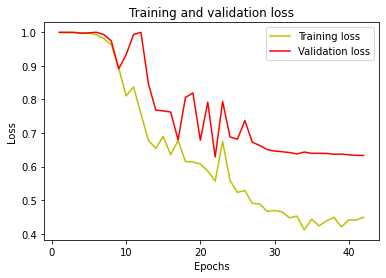

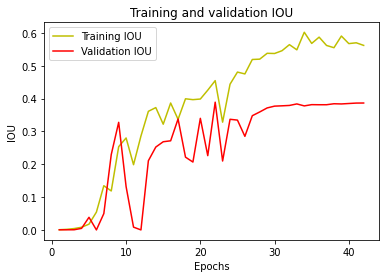

In [59]:
# plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

# Predict

In [132]:
# Load the pretrained model for testing and predictions. 
# you need a model instance before loading weights
print(f"Reload from : {MODEL_NAME}.best.hdf5")
# model.load_weights(f"{MODEL_NAME}_weights.best.hdf5")
model = tf.keras.models.load_model(f"{MODEL_NAME}.best.hdf5", compile=False)

Reload from : ./3D_model_resnet18_Noneweights_100epochs_jaccard_weights.best.hdf5


In [61]:
# Predict on the test data
y_pred = model.predict(np.expand_dims(X_test, axis=-1), batch_size=2)

11/11 [==============================] - 4s 358ms/step


In [105]:
THRESHOLD = 0.5

y_pred01 = (y_pred > THRESHOLD).astype(int).squeeze() # float => boolean => binary (0/1)

analytics(y_test, y_pred01)

# Confusion matrix - strangely long to compute
# cm = confusion_matrix(y_test.flatten(), 
#                       y_pred01.flatten())
# print('\nConfusion matrix :\n', cm)

------ AFTER THRESHOLDING AT 0.5 ------
> sm.metrics.IOUScore : tf.Tensor(0.37976108086932037, shape=(), dtype=float64)
> Precision : 0.5554570777412003
> Recall : 0.545578908096008
> Fscore : 0.5504736809084636


# Make some predictions, plot and save as GIF

In [115]:
# Test some random images

# pick a random test scan and its ground truth mask
test_img_number = random.randint(0, len(X_test)-1)
print(f'I choose test image n° {test_img_number} ...')

test_img = X_test[test_img_number]
ground_truth = y_test[test_img_number]

# process input image before prediction
test_img_input = np.expand_dims(test_img, 0)
# test_img_input1 = preprocess_input(test_img_input)

# prediction
test_pred = model.predict(np.expand_dims(test_img_input, axis=-1))
test_pred = test_pred.squeeze()
test_pred01 = (test_pred > THRESHOLD).astype(int) # boolean => binary (0/1)

# thresholding + reshaping
print(test_pred.shape)

I choose test image n° 10 ...
1/1 [==============================] - 0s 26ms/step
(64, 192, 192)


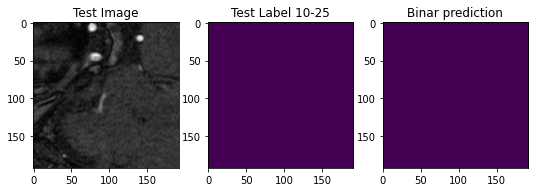

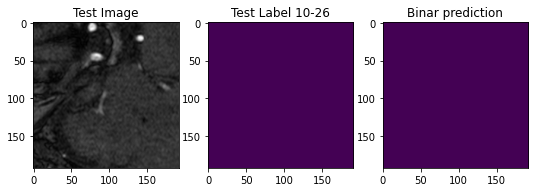

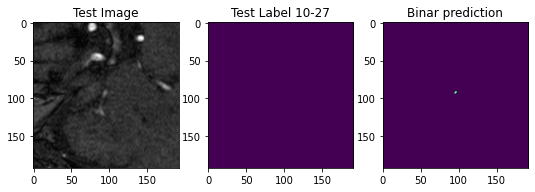

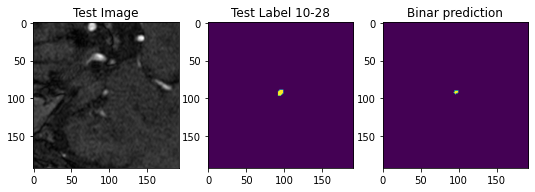

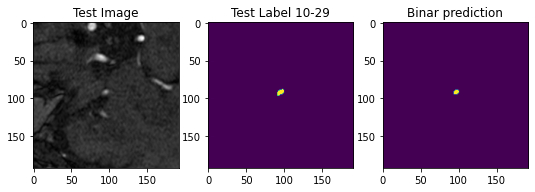

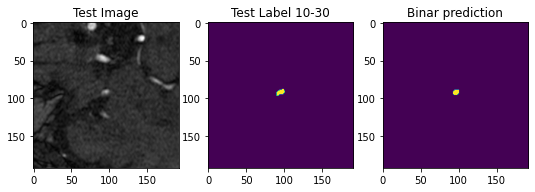

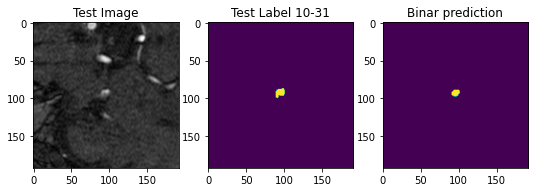

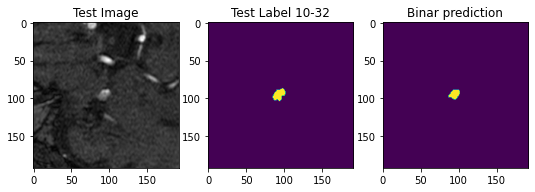

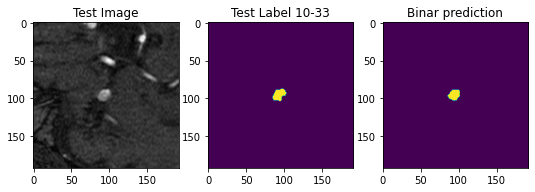

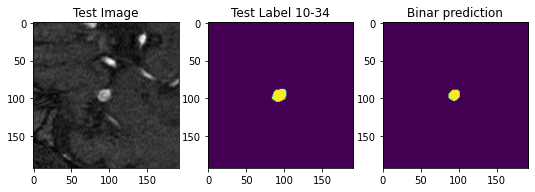

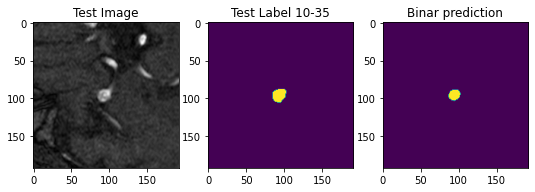

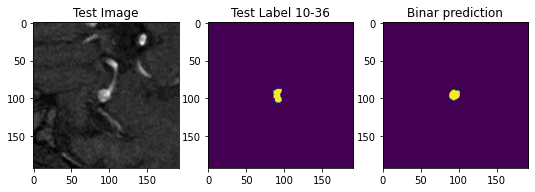

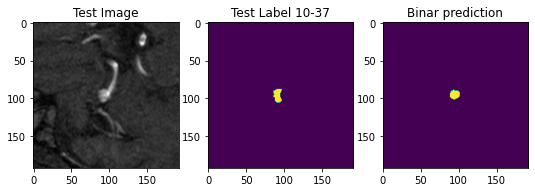

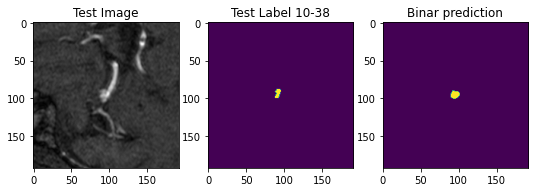

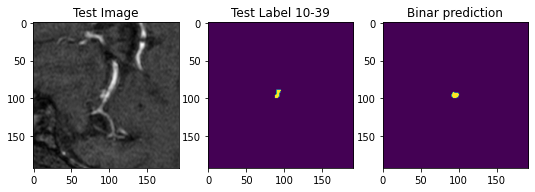

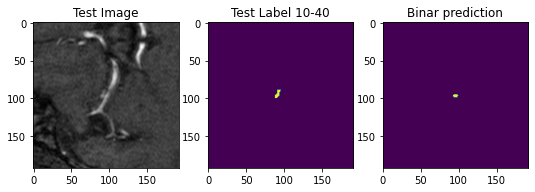

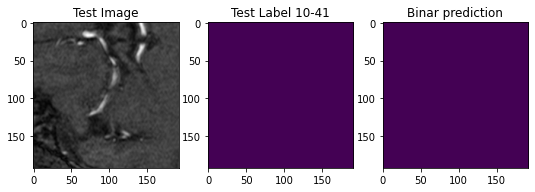

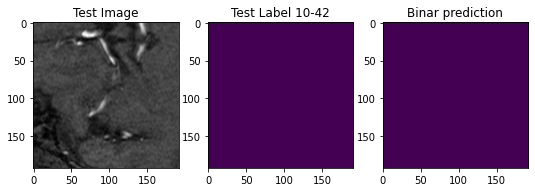

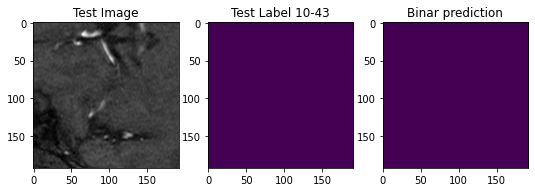

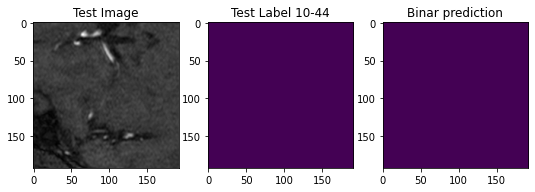

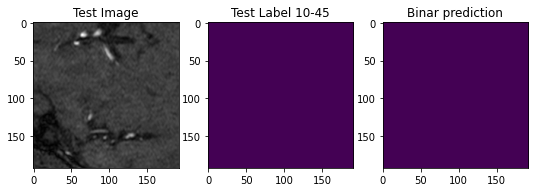

In [116]:
# Plot individual slices from test predictions for verification
SLICE_MIN, SLICE_MAX = 25, 45
SAVE_PATH = '/content/plots'

os.makedirs(SAVE_PATH, exist_ok=True)

for slice in range(SLICE_MIN, SLICE_MAX+1):
    plt.figure(figsize=(12, 8))
    plt.subplot(241)
    plt.title(f'Test Image')
    plt.imshow(test_img[slice,:,:], cmap='gray')
    plt.subplot(242)
    plt.title(f'Test Label {test_img_number}-{slice}')
    plt.imshow(ground_truth[slice,:,:])
    # plt.subplot(243)
    # plt.title(f'Prediction on test image {slice}')
    # plt.imshow(test_pred[slice,:,:])
    plt.subplot(243)
    plt.title(f'Binar prediction')
    plt.imshow(test_pred01[slice,:,:])
    plt.savefig(f'{SAVE_PATH}/slice_{slice}.png')
    plt.show()

In [117]:
# create a GIF

from PIL import Image
import glob

# Create the frames
frames = []
imgs = sorted(glob.glob(f"{SAVE_PATH}/*.png"))
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

# Save into a GIF file that loops forever
os.makedirs('/content/gifs', exist_ok=True)

frames[0].save(f'/content/gifs/scan{test_img_number}_to_gif.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)